In [2]:
import mne
import sys
import os
import importlib


from braindecode.preprocessing.preprocess import preprocess, Preprocessor, zscore
from braindecode.datasets import (create_from_mne_raw, create_from_mne_epochs)
from braindecode.preprocessing.windowers import create_windows_from_events
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datasets import BaseDataset, BaseConcatDataset, WindowsDataset

from plot import Plot
from segment import Segmenter

import matplotlib.pyplot as plt

In [3]:
from mat73 import loadmat

In [4]:
import mne
from mne_extras import write_edf

import os
from tqdm import tqdm

In [60]:

import pprint

pp = pprint.PrettyPrinter(indent=2)

# data_dir = '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/'
data_dir = '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/'


In [63]:
files = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir)]
# subject_files = [os.path.join(files[0], fname) for fname in os.listdir(files[0])]
# recordings = [os.path.join(subjects[0], fname) for fname in os.listdir(subjects[0])]

In [64]:
files

['/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal',
 '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/normal']

In [52]:
def get_file_list(x):
    return [os.path.join(x, fname) for fname in os.listdir(x)]

def get_id(x):
    return x.split('/')[-1]

In [208]:
annotations = {}
for annotation in get_file_list(data_dir):
    subjects = {}
    for subject in get_file_list(annotation):
        recordings = {}
        for recording in get_file_list(subject):
            dates = {}
            for date in get_file_list(recording):
                for raw_path in get_file_list(date):
                    if '.edf' in get_id(raw_path):
                        break
                    else:
                        pass
                dates[get_id(date)] = raw_path
            recordings[get_id(recording)] = dates
        subjects[get_id(subject)] = recordings
    annotations[get_id(annotation)] = subjects



pp.pprint(annotations)


{ 'abnormal': { '007': { '00000768': { 's003_2012_04_06': '/media/maligan/My '
                                                          'Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf'}},
                '011': { '00001154': { 's007_2012_07_25': '/media/maligan/My '
                                                          'Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/011/00001154/s007_2012_07_25/00001154_s007_t000.edf'}},
                '012': { '00001217': { 's002_2012_09_17': '/media/maligan/My '
                                                          'Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/012/00001217/s002_2012_09_17/00001217_s002_t000.edf'}},
                '021': { '00002118': { 's006_2013_08_16': '/media/maligan/My '
                                                          'Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/021/0000

In [434]:
import pandas as pd

df = pd.json_normalize(annotations, sep='_').T

# paths list
raw_paths = [df.iloc[i][0] for i in range(len(df))]

# define abnormal and normal subjects
abnormal_subjects = annotations['abnormal'].keys()
normal_subjects = annotations['normal'].keys()

# define descriptions (recoding per subject)
abnormal_descriptions, normal_descriptions, classification = [], [], []
for id in abnormal_subjects:
    for recording in annotations['abnormal'][id].values():
        for x in recording.keys():
            abnormal_descriptions += [{'subject': id, 'recording': x}]
            classification += ['abnormal']
for id in normal_subjects:
    for recording in annotations['normal'][id].values():
        for x in recording.keys():
            normal_descriptions += [{'subject': id, 'recording': x}]
            classification += ['normal']

descriptions = abnormal_descriptions + normal_descriptions

In [435]:
from sklearn.utils import shuffle
raw_paths, descriptions, classification = shuffle(raw_paths, descriptions, classification)

In [437]:
# [print(id) for id in abnormal_subjects ]
# [print(x) for x in annotations['abnormal']['072']]

# len(descriptions)
# len(raw_paths)
# len(classification)


In [357]:

raw = mne.io.read_raw_edf('/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf')

Extracting EDF parameters from /media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [387]:
sfreq = 100
high_cut_hz = 30
low_cut_hz = 0.5
n_jobs = 1

# preprocessing
# for raw in raws:
mne.io.Raw.resample(raw, sfreq)   # resample
mne.io.Raw.filter(raw, l_freq=low_cut_hz, h_freq=high_cut_hz, n_jobs=n_jobs)    # high-pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 sec)



<RawEDF | 00000768_s003_t000.edf, 30 x 121700 (1217.0 s), ~27.9 MB, data loaded>

In [402]:
raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['abnormal']))

In [331]:
ssl_sample = mne.io.read_raw_edf('/media/maligan/My Passport/msc_thesis/ssl_thesis/data/sleep_staging_sample/SC4012E0-PSG.edf')
ssl_sample

Extracting EDF parameters from /media/maligan/My Passport/msc_thesis/ssl_thesis/data/sleep_staging_sample/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Annotations | 0 segments>

,0
abnormal_072_00007221_s001_2010_10_27,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_072_00007221_s002_2010_11_01,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_007_00000768_s003_2012_04_06,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_011_00001154_s007_2012_07_25,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_012_00001217_s002_2012_09_17,/media/maligan/My Passport/msc_thesis/ssl_thes...
...,...
normal_105_00010577_s001_2013_07_24,/media/maligan/My Passport/msc_thesis/ssl_thes...
normal_106_00010660_s001_2013_08_19,/media/maligan/My Passport/msc_thesis/ssl_thes...
normal_106_00010680_s001_2013_08_22,/media/maligan/My Passport/msc_thesis/ssl_thes...
normal_107_00010725_s001_2013_09_10,/media/maligan/My Passport/msc_thesis/ssl_thes...


In [428]:

# load data and set annotations
dataset = []
for i, path in enumerate(raw_paths):
    # classification = 'abnormal' if  else 'normal'
    print(df.iloc[i].name.split('_')[0])
    
    # raw = mne.io.read_raw_fif(path)
    # raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['abnormal']))
    # dataset.append(raw)


abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
abnormal
a

In [153]:
raw = annotations['abnormal']['021']['00002118']['s006_2013_08_16']
raw = mne.io.read_raw_edf(raw)
# raw.ch_names

Extracting EDF parameters from /media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/021/00002118/s006_2013_08_16/00002118_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [142]:
import pandas as pd

df = pd.json_normalize(annotations, sep='_').T
df

,0
abnormal_072_00007221_s001_2010_10_27,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_072_00007221_s002_2010_11_01,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_007_00000768_s003_2012_04_06,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_011_00001154_s007_2012_07_25,/media/maligan/My Passport/msc_thesis/ssl_thes...
abnormal_012_00001217_s002_2012_09_17,/media/maligan/My Passport/msc_thesis/ssl_thes...
...,...
normal_105_00010577_s001_2013_07_24,/media/maligan/My Passport/msc_thesis/ssl_thes...
normal_106_00010660_s001_2013_08_19,/media/maligan/My Passport/msc_thesis/ssl_thes...
normal_106_00010680_s001_2013_08_22,/media/maligan/My Passport/msc_thesis/ssl_thes...
normal_107_00010725_s001_2013_09_10,/media/maligan/My Passport/msc_thesis/ssl_thes...


In [ ]:
# read, pick channels, save loop
for i in tqdm(range(len(df))):
    file = df.iloc[i][0]
    raw = mne.io.read_raw_edf(file)
    to_export = f"{file.split('/')[-1].split('.')[0]}"
    raw.save(f"{file}_2_channels.fif", picks=['EEG FZ-REF', 'EEG PZ-REF'], overwrite=True)


In [194]:
# shuffle two arrays the same way

import random

desc

random.seed(90)
random.shuffle(descriptions)
# reset the same seed to get the identical random sequence and shuffle the y
# random.seed(seed)
random.shuffle(y_data)

NameError: name 'desc' is not defined

In [255]:
pp.pprint(len(normal_descriptions+abnormal_descriptions))
pp.pprint(len(raw_paths))

247
269


In [ ]:
# read, pick channels, save loop
for file in tqdm(files):
    raw = mne.io.read_raw_edf('{file}')
    to_export = f"{file.split('/')[-1]}"
    raw.save(f"{data_dir}../eval_2_channels/{to_export}", picks=['Fpz', 'Pz'], overwrite=True)


In [22]:
data = mat73.loadmat('data/scopolamine/mats/CHDR0511.S2044.10MAY06_0942.O01M01.mat')
biomRegName = loadmat('data/scopolamine/biomRegName.mat')
classification = loadmat('data/scopolamine/ClassificationStatObj.mat')
dataMatrix = loadmat('data/scopolamine/DataMatrixScp1Scp5.mat')
mAChRindex = loadmat('data/scopolamine/mAChRindex.mat')
outcome = loadmat('data/scopolamine/Outcome.mat')

In [31]:
data['RawSignal']

array([[ 0.49962461, -0.65875173, -0.14366271,  0.01985283, -0.04261129,
        -0.02809451],
       [ 0.49962461, -0.65239894, -0.14367796,  0.01198544, -0.04263961,
        -0.02780316],
       [ 0.49962461, -0.66252047, -0.14350288,  0.02470998, -0.04259126,
        -0.0282714 ],
       ...,
       [ 0.49962461, -0.13753186,  0.04217241,  0.28275687, -0.04272525,
        -0.03777108],
       [ 0.49962461, -0.12997124,  0.0539127 ,  0.27765587, -0.04302568,
        -0.03681615],
       [ 0.49962461, -0.13421607,  0.0474169 ,  0.28051439, -0.04286418,
        -0.03732444]])

In [34]:
mne.io.RawArray(data['RawSignal'], mne.create_info(['Fz-Cz', 'Pz-Oz', '3','4','5','6'], 100))

ValueError: len(data) (64768) does not match len(info["ch_names"]) (6)

In [155]:

print('LOADING BCI DATA')

''' ANNOTATIONS
T0 corresponds to rest
T1 corresponds to onset of motion (real or imagined) of
    the left fist (in runs 3, 4, 7, 8, 11, and 12)
    both fists (in runs 5, 6, 9, 10, 13, and 14)
T2 corresponds to onset of motion (real or imagined) of
    the right fist (in runs 3, 4, 7, 8, 11, and 12)
    both feet (in runs 5, 6, 9, 10, 13, and 14)
'''

subject_size = [1,10]
subjects = range(subject_size[0], subject_size[1]) # max 110
event_codes = [
    1, 2, # eyes open, eyes closed (baselines)
    3, 4, 5,
    6, 7, 8, 9, 
    10, 11, 12, 13, 14
]

physionet_paths, descriptions = [], []

for subject_id in subjects:
    physionet_paths += [mne.datasets.eegbci.load_data(subject_id, event_codes, update_path=False)]
    descriptions += [{"event_code": code, "subject": subject_id} for code in event_codes]


LOADING BCI DATA


In [197]:
# raw_set = [
#     '/home/maligan/mne_data/physionet-sleep-data/SC4012E0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4451F0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4441E0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4431E0-PSG.edf',
#     '/home/maligan/mne_data/physionet-sleep-data/SC4421E0-PSG.edf',
# ]

# space_bambi directory
data_dir = './data/SPACE_BAMBI_2channels/'
raw_set = [
    f'{data_dir}SPACE.S175.yyyymmdd.EORASD_raw.fif',
    f'{data_dir}SPACE.S170.yyyymmdd.EORASD_raw.fif'
]

print(raw_set)

# load into raw array
raws = [mne.io.read_raw_fif(x, preload=True) for x in raw_set]

['./data/SPACE_BAMBI_2channels/SPACE.S175.yyyymmdd.EORASD_raw.fif', './data/SPACE_BAMBI_2channels/SPACE.S170.yyyymmdd.EORASD_raw.fif']
Opening raw data file ./data/SPACE_BAMBI_2channels/SPACE.S175.yyyymmdd.EORASD_raw.fif...
    Range : 0 ... 628735 =      0.000 ...   307.000 secs
Ready.
Reading 0 ... 628735  =      0.000 ...   307.000 secs...
Opening raw data file ./data/SPACE_BAMBI_2channels/SPACE.S170.yyyymmdd.EORASD_raw.fif...
    Range : 0 ... 616447 =      0.000 ...   301.000 secs
Ready.
Reading 0 ... 616447  =      0.000 ...   301.000 secs...


In [3]:
# space_bambi directory
data_dir = './data/SPACE_BAMBI_2channels/'

raws = []

print(f'{len(os.listdir(data_dir))} files found')
for i, path in enumerate(os.listdir(data_dir)):
    if i == 5:
        break
    full_path = os.path.join(data_dir, path)
    raws.append(mne.io.read_raw_fif(full_path, preload=True))

340 files found
Opening raw data file ./data/SPACE_BAMBI_2channels/SPACE.S27.yyyymmdd.ECRASD_raw.fif...
    Range : 0 ... 368639 =      0.000 ...   180.000 secs
Ready.
Reading 0 ... 368639  =      0.000 ...   180.000 secs...
Opening raw data file ./data/SPACE_BAMBI_2channels/BAMBI.S620.yyyymmdd.EORASD1_raw.fif...
    Range : 0 ... 618495 =      0.000 ...   302.000 secs
Ready.
Reading 0 ... 618495  =      0.000 ...   302.000 secs...
Opening raw data file ./data/SPACE_BAMBI_2channels/SPACE.S50.yyyymmdd.EORASD_raw.fif...
    Range : 0 ... 378879 =      0.000 ...   185.000 secs
Ready.
Reading 0 ... 378879  =      0.000 ...   185.000 secs...
Opening raw data file ./data/SPACE_BAMBI_2channels/SPACE.S101.yyyymmdd.EORHE_raw.fif...
    Range : 0 ... 622591 =      0.000 ...   304.000 secs
Ready.
Reading 0 ... 622591  =      0.000 ...   304.000 secs...
Opening raw data file ./data/SPACE_BAMBI_2channels/SPACE.S94.yyyymmdd.EORHE_raw.fif...
    Range : 0 ... 731135 =      0.000 ...   357.000 secs
Re

In [164]:
# import pandas as pd
# descriptions = []

# for id, raw in enumerate(raws):
#     descriptions += [{
#         id: {
#         "onset": annot['onset'], 
#         "duration": annot['duration'], 
#         "description": annot['description'], 
#         "orig_time": annot['orig_time']
#         }
#     } for annot in raw.annotations]

In [199]:
descriptions = []

for subject_id, raw in enumerate(raws):
    descriptions += [{"subject": subject_id}]

In [202]:
descriptions[0]

{'event_code': 1, 'subject': 1}

In [205]:
raws[0].ch_names

['Fpz', 'Pz']

In [201]:

event_codes = [
    1, 2, # eyes open, eyes closed (baselines)
    3, 4, 5,
    6, 7, 8, 9, 
    10, 11, 12, 13, 14
]

physionet_paths, descriptions = [], []

for subject_id in subjects:
    physionet_paths += [mne.datasets.eegbci.load_data(subject_id, event_codes, update_path=False)]
    descriptions += [{"event_code": code, "subject": subject_id} for code in event_codes]


In [76]:
descriptions

[{'event_code': 1, 'subject': 1},
 {'event_code': 2, 'subject': 1},
 {'event_code': 3, 'subject': 1},
 {'event_code': 4, 'subject': 1},
 {'event_code': 5, 'subject': 1},
 {'event_code': 6, 'subject': 1},
 {'event_code': 7, 'subject': 1},
 {'event_code': 8, 'subject': 1},
 {'event_code': 9, 'subject': 1},
 {'event_code': 10, 'subject': 1},
 {'event_code': 11, 'subject': 1},
 {'event_code': 12, 'subject': 1},
 {'event_code': 13, 'subject': 1},
 {'event_code': 14, 'subject': 1},
 {'event_code': 1, 'subject': 2},
 {'event_code': 2, 'subject': 2},
 {'event_code': 3, 'subject': 2},
 {'event_code': 4, 'subject': 2},
 {'event_code': 5, 'subject': 2},
 {'event_code': 6, 'subject': 2},
 {'event_code': 7, 'subject': 2},
 {'event_code': 8, 'subject': 2},
 {'event_code': 9, 'subject': 2},
 {'event_code': 10, 'subject': 2},
 {'event_code': 11, 'subject': 2},
 {'event_code': 12, 'subject': 2},
 {'event_code': 13, 'subject': 2},
 {'event_code': 14, 'subject': 2},
 {'event_code': 1, 'subject': 3},
 {'e

In [4]:
### preprocess
# resample to 160Hz
# high pass filtering of 30Hz

sfreq = 160
high_cut_hz = 30
n_jobs = 2

for raw in raws:
    mne.io.Raw.resample(raw, sfreq, n_jobs=n_jobs) # resample all files
    mne.io.Raw.filter(raw, l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs) # high-pass filter

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 71 samples (0.444 sec)



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


In [5]:
base_datasets = [BaseDataset(raw) for raw in raws]
base_concat_datasets = BaseConcatDataset(base_datasets)

In [6]:
base_concat_datasets

In [7]:
window_size_samples = 100

windows_dataset = create_from_mne_raw(
    raws,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    drop_last_window=True,
    # descriptions=descriptions,
    accepted_bads_ratio=0.5,
    drop_bad_windows=True,
    # mapping=mapping,
    # preload=True,
    on_missing='ignore'
)


Used Annotations descriptions: ['artifact']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
112 matching events found
No baseline correction applied
0 projection items activated
Loading data for 112 events and 100 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['artifact']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
120 matching events found
No baseline correction applied
0 projection items activated
Loading data for 120 events and 100 original time points ...
0 bad epochs dropped


In [8]:
type(windows_dataset)

braindecode.datasets.base.BaseConcatDataset

In [9]:
# z-score normalization

preprocess(windows_dataset, Preprocessor(zscore))


Loading data for 112 events and 100 original time points ...
Loading data for 120 events and 100 original time points ...


/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
path = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/SPACE_BAMBI_2channels/SPACE.S170.yyyymmdd.EORASD_raw.fif'

raw = mne.io.read_raw_fif(path)
raw

Opening raw data file /home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/SPACE_BAMBI_2channels/SPACE.S170.yyyymmdd.EORASD_raw.fif...
    Range : 0 ... 616447 =      0.000 ...   301.000 secs
Ready.


<Raw | SPACE.S170.yyyymmdd.EORASD_raw.fif, 2 x 616448 (301.0 s), ~35 kB, data not loaded>

In [4]:
importlib.reload(sys.modules['segment'])

<module 'segment' from '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/segment.py'>

In [3]:
segmenter = Segmenter()
raw = mne.io.read_raw_fif('/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/SPACE_BAMBI_2channels/SPACE.S175.yyyymmdd.EORASD_raw.fif')

Opening raw data file /home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/SPACE_BAMBI_2channels/SPACE.S175.yyyymmdd.EORASD_raw.fif...
    Range : 0 ... 628735 =      0.000 ...   307.000 secs
Ready.


In [4]:
mapped_segments = segmenter.segment(raw)

In [5]:
raw.info

<Info | 11 non-empty values
 bads: []
 ch_names: Fpz, Pz
 chs: 2 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 1024.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 2
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 1 item (dict)
>

In [6]:
raw.annotations

<Annotations | 21 segments: artifact (21)>

In [15]:
# Print results
ids = [e[2] for e in mapped_segments.events]  # all ids
idx_ignore = [id for id, id_ in enumerate(ids) if id_ == 2]  # ids of segments to ignore
idx_artifacts = [id for id, id_ in enumerate(ids) if id_ == 0]  # ids of artifact segments
idx_nonartifacts = [id for id, id_ in enumerate(ids) if id_ == 1]  # ids of nonartifact segments
print('Number of artifact segments is {}'.format(len(idx_artifacts)))
print('Number of non-artifact segments is {}'.format(len(idx_nonartifacts)))
print('Number of segments to ignore is {}'.format(len(idx_ignore)))

Number of artifact segments is 180
Number of non-artifact segments is 425
Number of segments to ignore is 8


In [20]:
import pathlib

dir_path = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/mats/raws/"

mats = os.listdir(dir_path)
mats

['CHDR0511.S2044.10MAY06_1224.O01M05.mat',
 'CHDR0511.S2044.10MAY06_0942.O01M01.mat']

In [105]:
from  mat73 import loadmat
import mne

raws = []
info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)

for mat in mats:
    print(mat)
    # select columns 3 and 4 (Fpz-Cz, and Pz-Oz respectively) and convert to microvolts
    x = loadmat(dir_path + mat)['RawSignal'][:, [2,3]].T / 100000
    raw = mne.io.RawArray(x, info)
    raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['scopolamine']))

raws

CHDR0511.S2044.10MAY06_1224.O01M05.mat
Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.
CHDR0511.S2044.10MAY06_0942.O01M01.mat
Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.


[]

In [98]:
info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)
raw = mne.io.RawArray(dataset[0], info)
# raw.plot()

Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.


In [108]:
from  mat73 import loadmat
import mne

print(':: loading SCOPOLAMINE data')

scop_dir = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/mats/raws/'

mats = os.listdir(scop_dir)

scp_raws, scp_desc = [], []
info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)

# creating scopolamine raw data
for i, mat in enumerate(mats):
    print(mat)
    # select columns 3 and 4 (Fpz-Cz, and Pz-Oz respectively) and convert to microvolts
    x = loadmat(scop_dir + mat)['RawSignal'][:, [2,3]].T / 100000
    raw = mne.io.RawArray(x, info)
    scp_raws += [raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=['scopolamine']))]
    scp_desc += [{'subject': 1, 'recording': i}]

# creating sample abnormal raw data
# ----------------------------- TEMP -------------------------------------------------

abn_dir = [
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf_2_channels.fif',
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/011/00001154/s007_2012_07_25/00001154_s007_t000.edf_2_channels.fif'
]
norm_dir = [
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/normal/006/00000647/s002_2009_09_21/00000647_s002_t000.edf_2_channels.fif',
    '/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/normal/013/00001355/s003_2009_12_08/00001355_s003_t000.edf_2_channels.fif'
]


# only 1 rec per subject (temporary)
def make_raws(_class, dataset=[], descriptions=[]):
    for i, path in enumerate(abn_dir):
        raw = mne.io.read_raw_fif(path)
        raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[_class]))
        dataset.append(raw)
        descriptions += [{'subject': len(descriptions)+1, 'recording': 1}]

    return dataset, descriptions
    
dataset, descriptions = make_raws('abnormal')
dataset, descriptions = make_raws('normal', dataset, descriptions)

dataset += scp_raws
descriptions += scp_desc

# -----------------------------------------------------------------------------------

for i, x in enumerate(dataset):
    print(dataset[i], descriptions[i])



:: loading SCOPOLAMINE data
CHDR0511.S2044.10MAY06_1224.O01M05.mat
Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.
CHDR0511.S2044.10MAY06_0942.O01M01.mat
Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.
Opening raw data file /media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf_2_channels.fif...


<ipython-input-108-1445fabc064b>:38: RuntimeWarning: This filename (/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf_2_channels.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path)


Isotrak not found
    Range : 0 ... 304249 =      0.000 ...  1216.996 secs
Ready.
Opening raw data file /media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/011/00001154/s007_2012_07_25/00001154_s007_t000.edf_2_channels.fif...
Isotrak not found
    Range : 0 ... 357249 =      0.000 ...  1428.996 secs
Ready.
Opening raw data file /media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf_2_channels.fif...
Isotrak not found
    Range : 0 ... 304249 =      0.000 ...  1216.996 secs
Ready.
Opening raw data file /media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/011/00001154/s007_2012_07_25/00001154_s007_t000.edf_2_channels.fif...
Isotrak not found
    Range : 0 ... 357249 =      0.000 ...  1428.996 secs
Ready.


<ipython-input-108-1445fabc064b>:38: RuntimeWarning: This filename (/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/011/00001154/s007_2012_07_25/00001154_s007_t000.edf_2_channels.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path)
<ipython-input-108-1445fabc064b>:38: RuntimeWarning: This filename (/media/maligan/My Passport/msc_thesis/ssl_thesis/data/tuh_abnormal_data/eval/abnormal/007/00000768/s003_2012_04_06/00000768_s003_t000.edf_2_channels.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path)
<ipython-input-108-1445fabc064b>:3

<Raw | 00000768_s003_t000.edf_2_channels.fif, 2 x 304250 (1217.0 s), ~8 kB, data not loaded> {'subject': 1, 'recording': 1}
<Raw | 00001154_s007_t000.edf_2_channels.fif, 2 x 357250 (1429.0 s), ~8 kB, data not loaded> {'subject': 2, 'recording': 1}
<Raw | 00000768_s003_t000.edf_2_channels.fif, 2 x 304250 (1217.0 s), ~8 kB, data not loaded> {'subject': 3, 'recording': 1}
<Raw | 00001154_s007_t000.edf_2_channels.fif, 2 x 357250 (1429.0 s), ~8 kB, data not loaded> {'subject': 4, 'recording': 1}
<RawArray | 2 x 64768 (64.0 s), ~1019 kB, data loaded> {'subject': 1, 'recording': 0}
<RawArray | 2 x 64768 (64.0 s), ~1019 kB, data loaded> {'subject': 1, 'recording': 1}


Not setting metadata
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


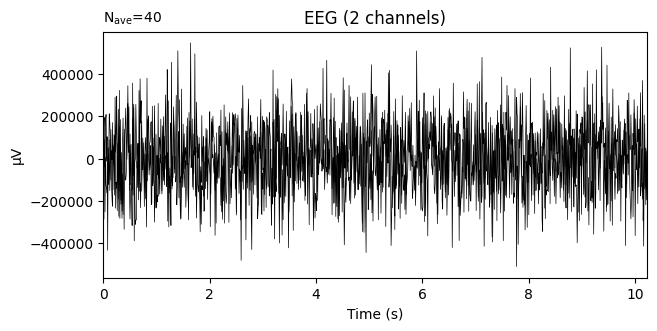

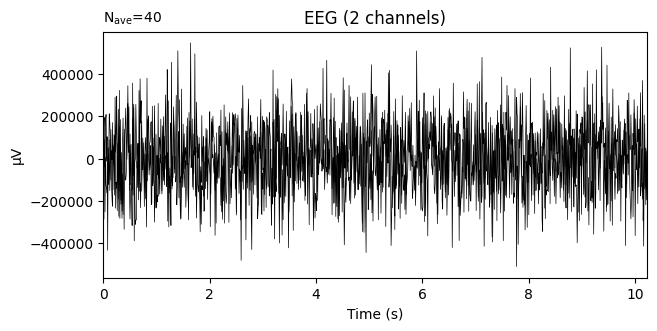

In [152]:
#  generate signal
import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet)
from mne.viz import centers_to_edges

sfreq = 100.0
ch_names = ['SIM0001', 'SIM0002']
ch_types = ['eeg'] *2
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

n_times = 1024  # Just over 1 second epochs
n_epochs = 40
seed = 42
rng = np.random.RandomState(seed)
noise = rng.randn(n_epochs, len(ch_names), n_times)

# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
on_time = np.logical_and(t >= 0.45, t <= 0.55)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

reject = dict(eeg=4000)
events = np.empty((n_epochs, 3), dtype=int)
first_event_sample = 100
event_id = dict(sin50hz=1)
for k in range(n_epochs):
    events[k, :] = first_event_sample + k * n_times, 0, event_id['sin50hz']

epochs = EpochsArray(data=data, info=info, events=events, event_id=event_id,
                     reject=reject)


epochs.average().plot()


In [164]:
ch_names = ['SIM0001', 'SIM0002']
ch_types = ['eeg'] *2
sfreq = 100.0
n_times = 1024

info = mne.create_info(ch_names, sfreq, ch_types=['eeg'] *2)

Creating RawArray with float64 data, n_channels=2, n_times=1024
    Range : 0 ... 1023 =      0.000 ...    10.230 secs
Ready.


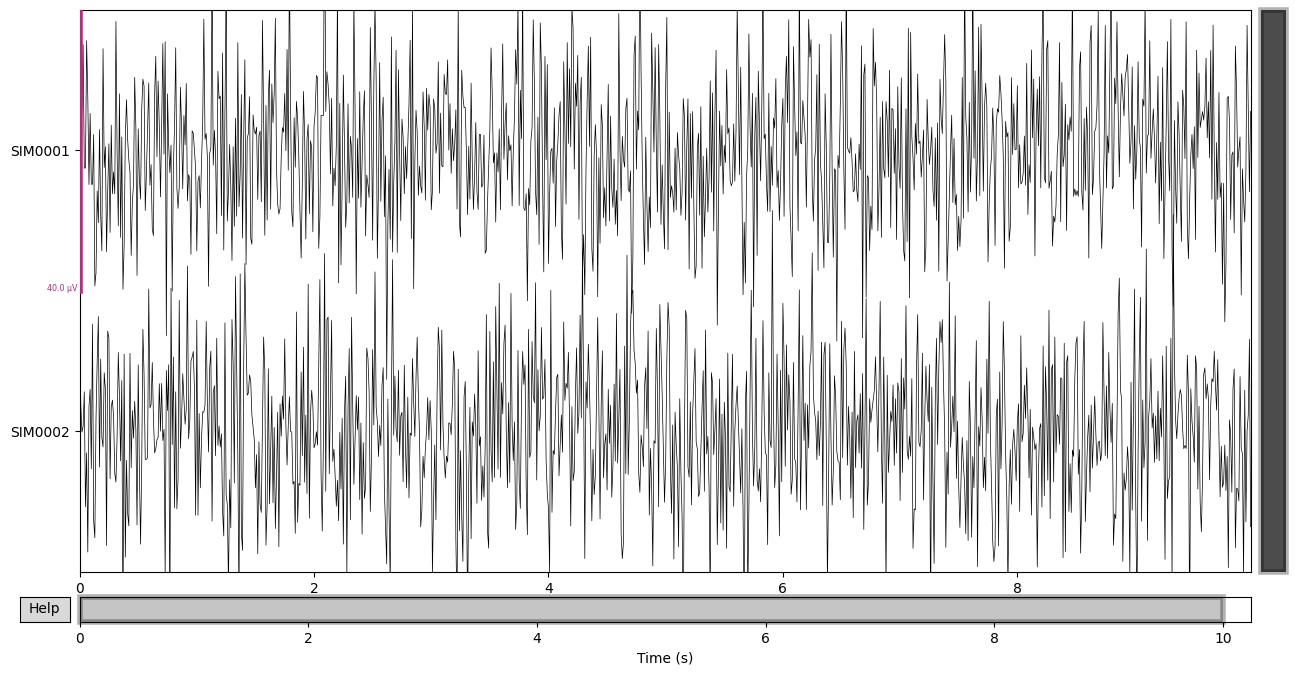

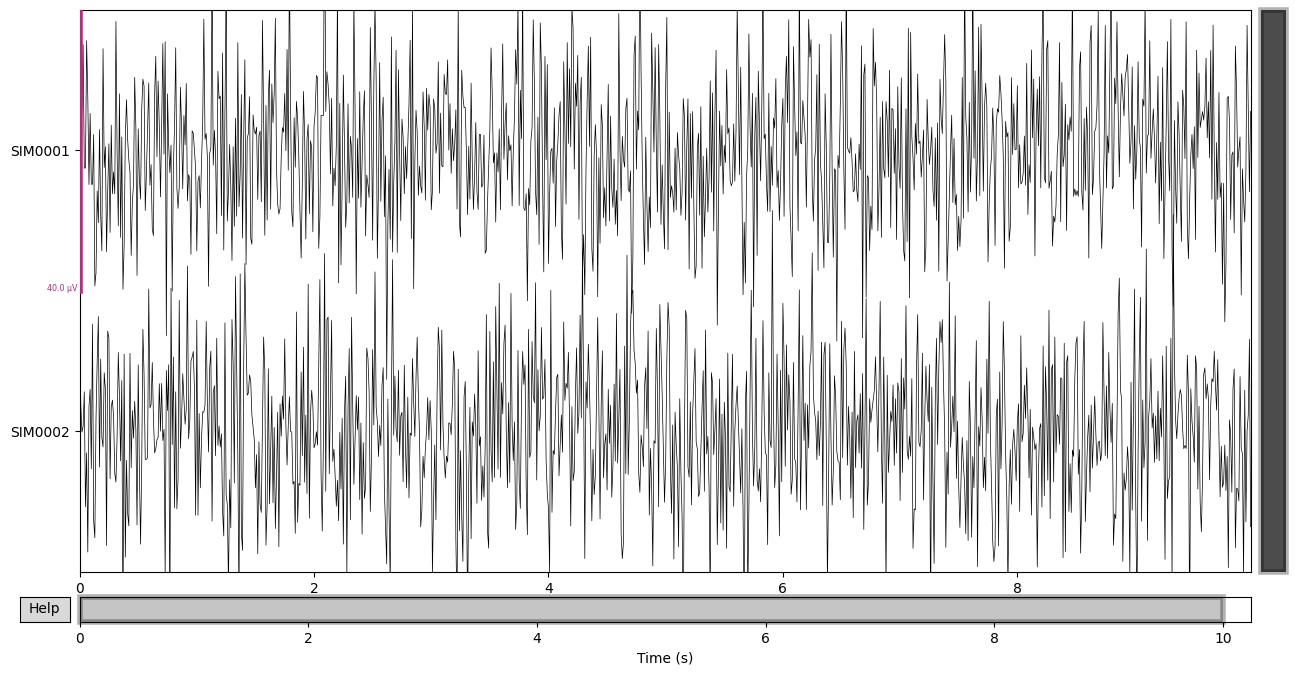

In [165]:
raw.plot()



In [190]:
ch_names=['SIM0001', 'SIM0002']
ch_types=['eeg']*2
sfreq=100.0
n_times=5000
seed=42
wave_hz=50.0
stage='noise'

rng = np.random.RandomState(seed)
noise = rng.randn(len(ch_names), n_times)

# Add a specified (50hz) sinusoidal burst to the noise and ramp it.
t = np.arange(n_times, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * wave_hz * t)  # wave_hz sinusoid signal
signal[np.logical_or(t < wave_hz-0.5, t > wave_hz+0.5)] = 0.  # Hard windowing
on_time = np.logical_and(t >= wave_hz-0.5, t <= wave_hz+0.5)
signal[on_time] *= np.hanning(on_time.sum())  # Ramping
data = noise + signal

info = mne.create_info(ch_names, sfreq, ch_types)
raw = mne.io.RawArray(data/100000, info)
raw = raw.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[stage]))

Creating RawArray with float64 data, n_channels=2, n_times=5000
    Range : 0 ... 4999 =      0.000 ...    49.990 secs
Ready.


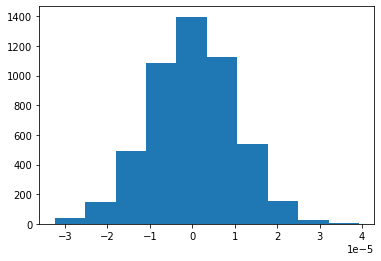

In [216]:
points = raw[:][0][:][0]

# %matplotlib inline

fig, ax = plt.subplots(1,1)
plt.hist(points)
plt.show()

In [265]:
ch_names=['SIM0001', 'SIM0002']
ch_types=['eeg']*2
sfreq=100.0
n_times=5000
seed=42
wave_hz=50.0
stage='white_noise'
bound=1

noise = np.array([
    np.random.uniform(wave_hz-bound, wave_hz+bound, size=n_times), 
    np.random.uniform(wave_hz-bound, wave_hz+bound, size=n_times)
])

# Add a specified (50hz) sinusoidal burst to the noise and ramp it.
# t = np.arange(n_times, dtype=np.float64) / sfreq
# signal = np.sin(np.pi * 2. * wave_hz * t)  # wave_hz sinusoid signal
# signal[np.logical_or(t < wave_hz-0.5, t > wave_hz+0.5)] = 0.  # Hard windowing
# on_time = np.logical_and(t >= wave_hz-0.5, t <= wave_hz+0.5)
# signal[on_time] *= np.hanning(on_time.sum())  # Ramping
# data = noise + signal

info = mne.create_info(ch_names, sfreq, ch_types)
white_noise = mne.io.RawArray(noise/100000, info)
white_noise = white_noise.set_annotations(mne.Annotations(onset=[0], duration=raw.times.max(), description=[stage]))

Creating RawArray with float64 data, n_channels=2, n_times=5000
    Range : 0 ... 4999 =      0.000 ...    49.990 secs
Ready.


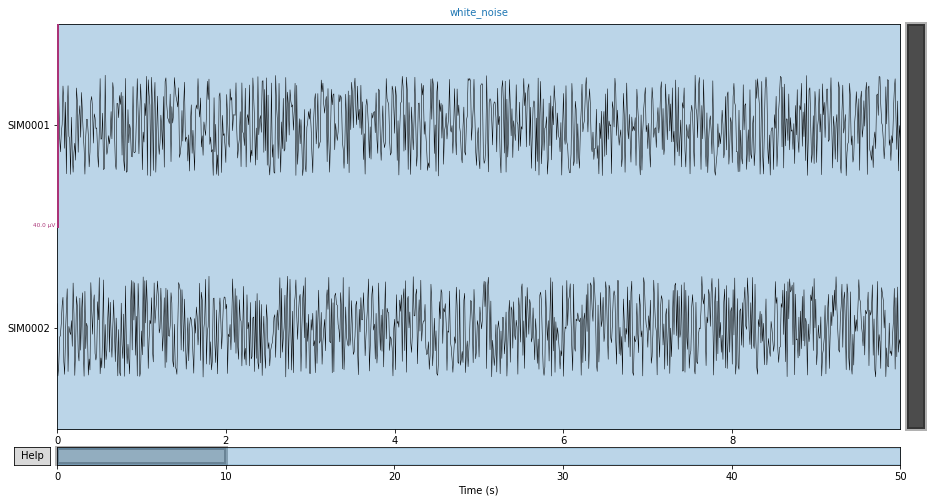

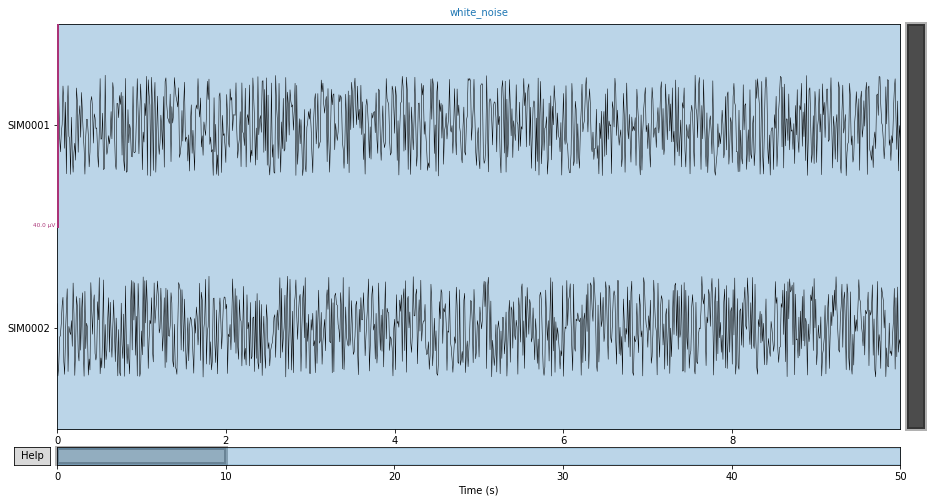

In [266]:
white_noise.plot()

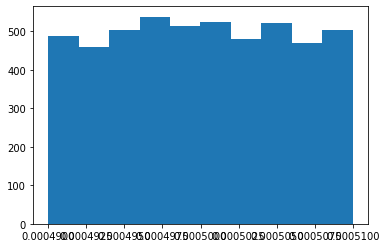

In [267]:
points = white_noise[:][0][:][0]

# %matplotlib inline

fig, ax = plt.subplots(1,1)
plt.hist(points)
plt.show()

In [230]:
white_noise[:][0][:][0]

array([ 4.96714153e-06, -1.38264301e-06,  6.47688538e-06, ...,
        3.11291020e-05,  8.08036189e-06, -8.48065598e-06])

In [271]:
from matplotlib import cm

n_stages = 2 
colors = cm.get_cmap('viridis', n_stages)(range(n_stages))

In [279]:
type(white_noise[0][0])

numpy.ndarray

In [4]:
from obspy.signal.tf_misfit import plot_tfr
import numpy as np

In [5]:
arr = np.random.randn(50)
print(arr.shape, len(arr))
print(np.max(arr), np.min(arr))

(50,) 50
1.82900251918 -2.58265758591


In [10]:
from mne.time_frequency import tfr_morlet

tfr_morlet(arr)

TypeError: tfr_morlet() missing 2 required positional arguments: 'freqs' and 'n_cycles'

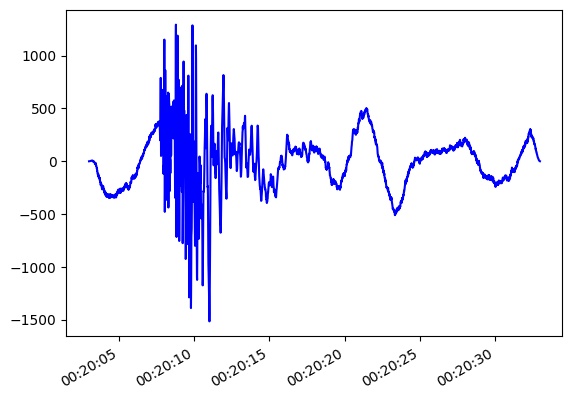

In [6]:
import matplotlib.pyplot as plt
from obspy import read

st = read()
tr = st[0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(tr.times("matplotlib"), tr.data, "b-")
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()

In [7]:
%matplotlib

fig, ax = plt.subplots(1,2)

ax = plot_tfr(arr, dt=0.1, h_2=2, w_2=2, show=False)


Using matplotlib backend: <object object at 0x7f7cc856dcb0>


## TF plots for scopolamine - visual inspection

In [21]:
%matplotlib inline

m01 = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/CHDR0507.S1001.06MAR06_0911.O04M01.mat'
m05 = '/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/ssl_thesis/data/scopolamine/CHDR0507.S1001.06MAR06_1237.O04M05.mat'

info = mne.create_info(ch_names=['Fpz-cz', 'Pz-Oz'], ch_types=['eeg']*2, sfreq=1012)

In [22]:
# scopolamine - M01
m01_raw = mne.io.RawArray((loadmat(m01)['RawSignal'][:, [2,3]].T / 100000), info)
m01_cropped = m01_raw.crop(0, 20)

Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.


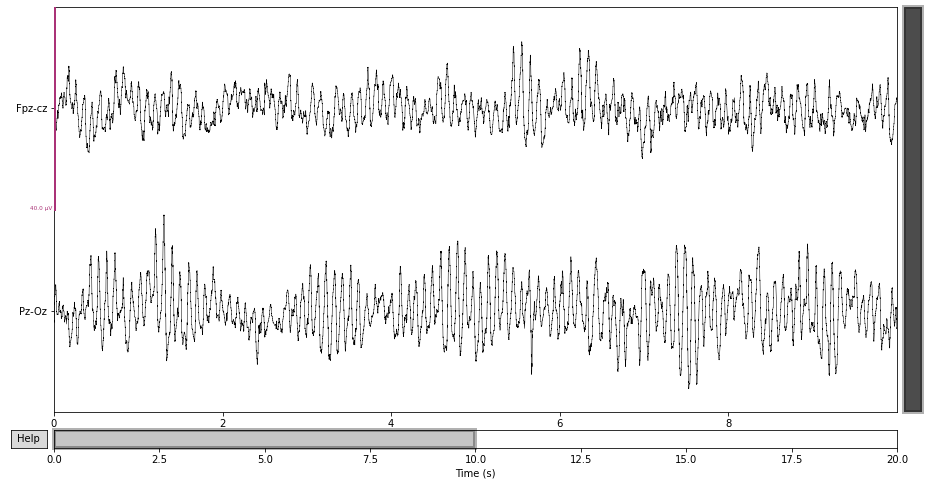

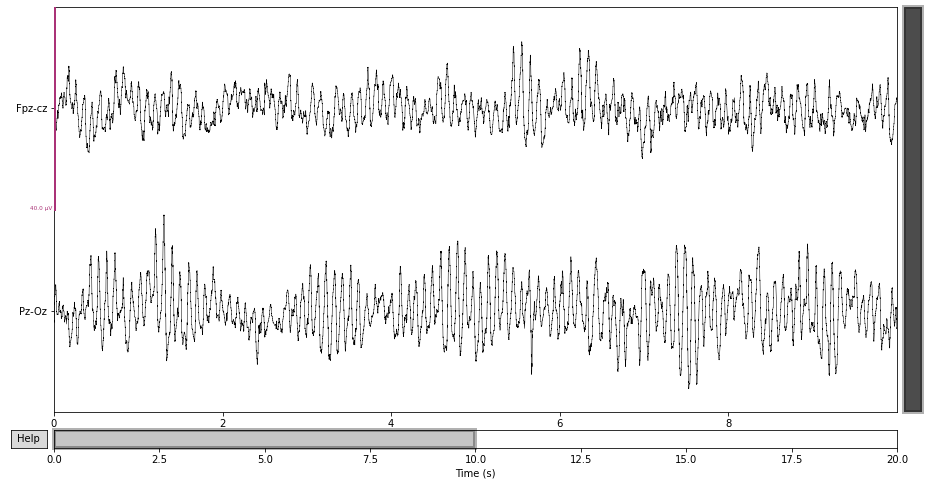

In [23]:
raw = m01_raw

raw.plot()

In [24]:
raw = raw.filter(l_freq=0.5, h_freq=30, n_jobs=1)
raw = raw.resample(100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6681 samples (6.602 sec)



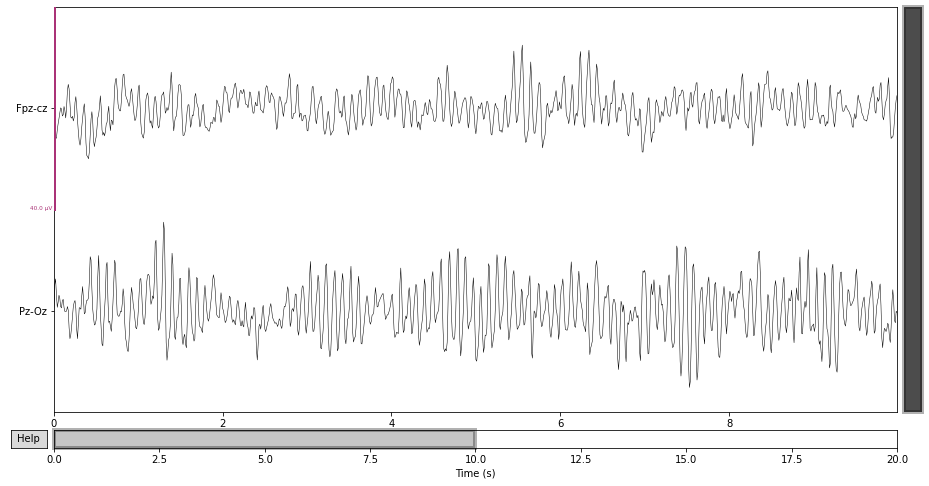

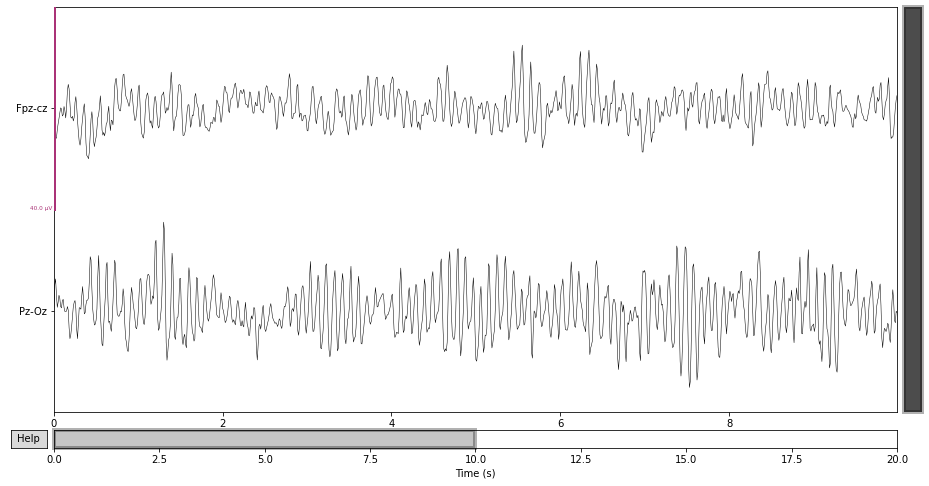

In [25]:
raw.plot()

In [407]:
# scopolamine - M05
m05_raw = mne.io.RawArray((loadmat(m05)['RawSignal'][:, [2,3]].T / 100000), info)
m05_cropped = m05_raw.crop(0, 20)

Creating RawArray with float64 data, n_channels=2, n_times=64768
    Range : 0 ... 64767 =      0.000 ...    63.999 secs
Ready.


In [408]:
# m05_cropped.plot()

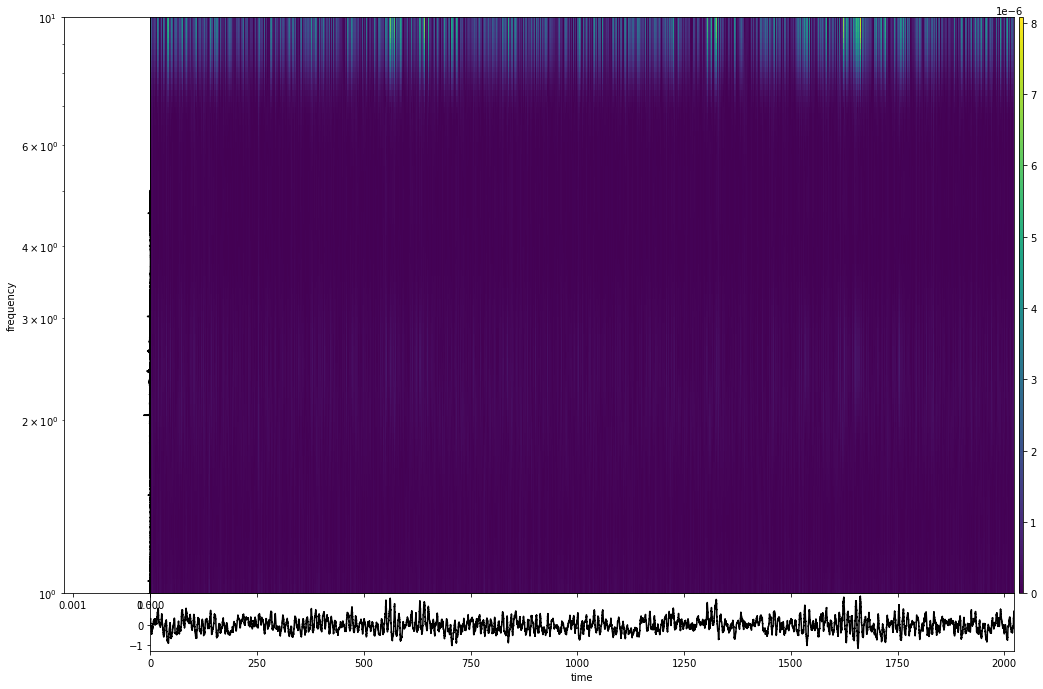

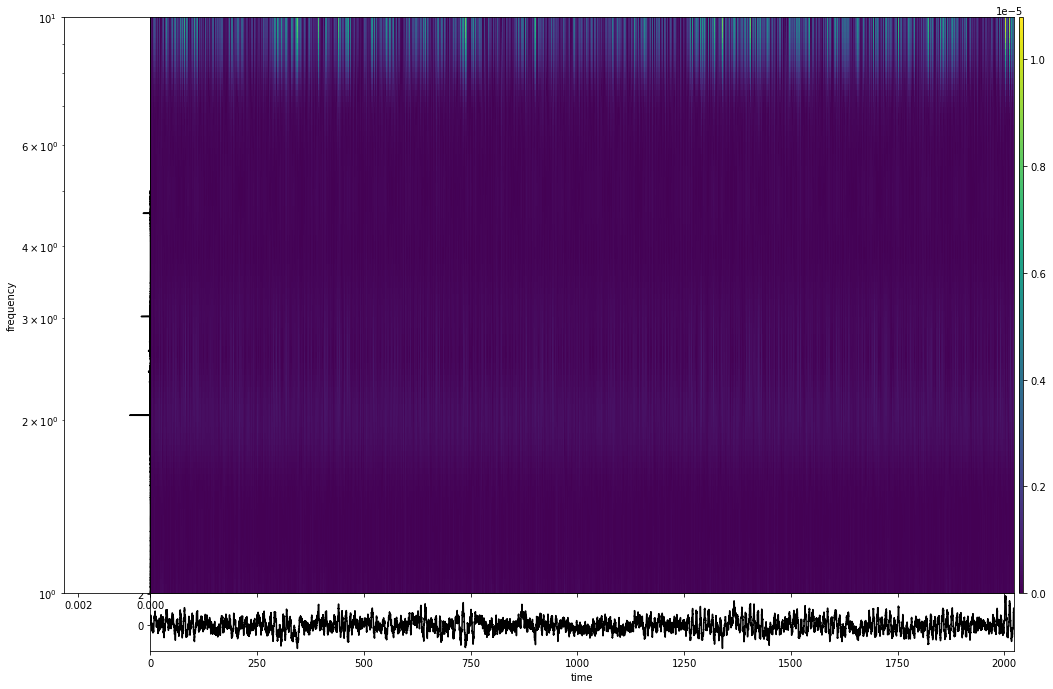

In [418]:
# Fpz_Cz
plot_tfr(m01_cropped[:][0][0], dt=0.1, h_2=2, w_2=2)
plot_tfr(m05_cropped[:][0][0], dt=0.1, h_2=2, w_2=2)

TypeError: float() argument must be a string or a number, not 'Figure'

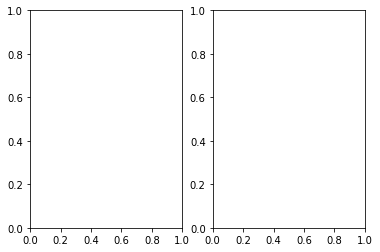

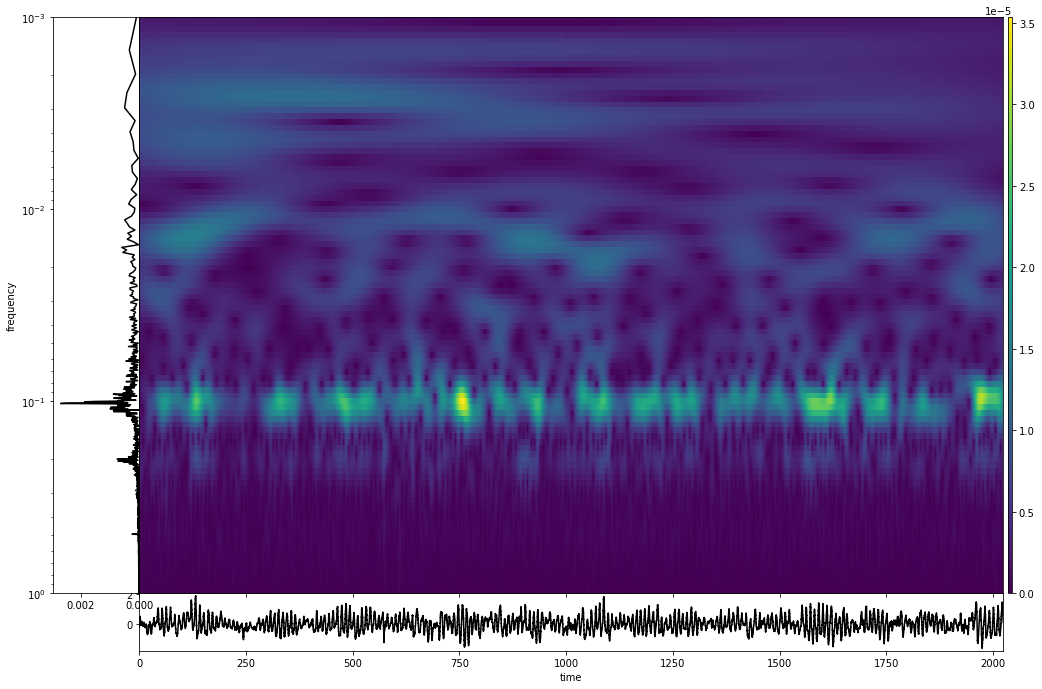

In [417]:
# Pz_Oz

fig, (ax1,ax2) = plt.subplots(1, 2)

ax = plot_tfr(m01_cropped[:][0][1], dt=0.1, h_2=2, w_2=2, fmax=0.001, show=False))
# plot_tfr(m05_cropped[:][0][1], dt=0.1, h_2=2, w_2=2, fmax=0.001)
plt.show()